### Auto-generated Instructions:

* First, edit this Markdown cell and add your name and date below. 
* Then read through the assignment and fill in any place that says `YOUR CODE HERE` (Python code cells) or "YOUR ANSWER HERE" (Markdown cells).
* Write in complete sentences and justify your answers whenever possible. Presentation counts! Your file should be organized, readable, and free of typos.
* Before submitting, make sure everything runs as expected, e.g. with `Kernel`$\rightarrow$ `Restart and Run All`.
---

### ITEC 600 Notebook
* Christopher Izenour
* March 17, 2021
---

# ITEC 600 Data Analysis Project
## Christopher Izenour
## March 17, 2021

* Add your name above
* Write your report below, adding Python and/or Markdown cells as necessary for each section.


# Introduction


### NFL Scoring Is Up, Are Quarterbacks the Cause?

For this data analysis effort, I chose to perform analysis on a collection of National Football League (NFL) statistics scraped from www.nfl.com by Kendal Gillies (https://www.kaggle.com/kendallgillies/nflstatistics). Her NFL Stats folder on Kaggle includes datasets that comprise basic information regarding players that played in the NFL, individual career stats broken down by positional groups, and game stats for many players (since 1970) broken down by positional groups. I supplemented my data with data pulled from Pro Football Reference (PFR) (www.pro-football-reference.com). I used PFR to pull the Hall of Fame player dataset for inclusion in this analysis because the datasets scraped from the NFL did not include Hall of Fame status for the player.

Ultimately, the dataset that served as the foundation of my analysis effort was the csv file Game_Logs_Quarterback. I sought to explore the extent to which the performance of quarterbacks can explain the increase in average team points per game between 1970 and the end of 2016 (47 years of games). My hypothesis is:

* NFL team scoring averages since 1970 have increased as a result of improved quarterback performance.

This dataset includes an observation for a majority of players who have played quarterback since the start of the 1970 season. The range of games spanned preseason, regular season, playoffs and Pro Bowls. The dataset included statistical categories such as pass attempts, completions, yards, touchdowns, interceptions, sacks and fumbles.

In the process of cleaning the data and preparing it for analysis, I narrowed the scope of available observations using the following steps:

- dropping columns not primarily associated with quarterback skill (sacks, fumbles)
- filtering out observations from pre-season, post-season and Pro Bowls
- filtering out observations where the column games_played was equal to 0
- filtering out observations where the player did not attempt at least 5 passes in his game appearance

The resulting database was then grouped by year and week to allow for calculating the mean of the following statistics:

- passes completed
- passes attempted
- passing yards
- touchdown passes
- interceptions
- team score

These statistics provided for the calculation of performance ratios. The ratios allowed me to better compare statistics between years and weeks without outlier performances completely skewing the results. The performance ratios used in the analysis include:

- completion percentage
- passing yards per attempt
- passing attempts per touchdown
- passing attempts per interception




# Exploratory Data Analysis


#### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import scipy.stats as stats


from scipy.stats import pearsonr

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors



#### Global Variables

In [2]:
# https://www.pro-football-reference.com/about/minimums.htm
career_min_att = 1500
modern_era_cutoff = 1970
game_pass_attempts_min = 5

## Data Wrangling and Dataframe Creation

#### Pro Football Reference's Player Hall of Fame Dataset

The Hall of Fame dataset was utilized as part of an earlier analytical effort on quarterback performance. It remained as part of this effort in case I decided to use Hall of Fame status as a category for evaluation.

In [3]:
###############################
# Hall of Fame dataset wrangling
###############################

# scrape hall of fame players table
hof = pd.read_html('https://www.pro-football-reference.com/hof/')
hof = hof[0]
hof

# flatten column name multi-index and rename columns
hof.columns = ['_'.join(col).strip() for col in hof.columns.values]
hof = hof.copy()
hof.rename(columns={'Unnamed: 0_level_0_Rk': 'rk',
                    'Unnamed: 1_level_0_Player': 'player_name',
                    'Unnamed: 2_level_0_Pos': 'position',
                    'Unnamed: 3_level_0_Indct': 'yr_inducted',
                    'Unnamed: 4_level_0_From': 'first_yr',
                    'Unnamed: 5_level_0_To': 'last_yr',
                    'Unnamed: 6_level_0_AP1': 'first_team_all_pro',
                    'Unnamed: 7_level_0_PB': 'pro_bowl',
                    'Unnamed: 8_level_0_St': 'yrs_primary_starter',
                    'Unnamed: 9_level_0_CarAV': 'weighted_career_approx_value',
                    'Unnamed: 10_level_0_G': 'games_played',
                    'Passing_Cmp': 'passing_completions',
                    'Passing_Att': 'passing_attempts',
                    'Passing_Yds': 'passing_yards',
                    'Passing_TD': 'passing_touchdowns',
                    'Passing_Lng': 'longest_pass_completion',
                    'Passing_Int': 'interceptions_thrown',
                    'Passing_Sk': 'times_sacked',
                    'Passing_Yds.1': 'yds_lost_from_sacks',
                    'Rushing_Att': 'rushing_attempts',
                    'Rushing_Yds': 'rushing_yards',
                    'Rushing_TD': 'rushing_touchdowns',
                    'Rushing_Lng': 'longest_rushing_attempt',
                    'Receiving_Rec': 'receptions',
                    'Receiving_Yds': 'receiving_yards',
                    'Receiving_TD': 'receiving_touchdowns',
                    'Receiving_Lng': 'longest_reception'}, inplace=True)

# remove rk column
hof.drop(columns=['rk'], axis=1, inplace=True)

# set player name to lower case and remove spaces
hof['player_name'] = hof['player_name'].str.lower()
hof['player_name'] = hof['player_name'].str.replace(' ', '')
hof

# slice out Hall of Fame Quarterback from the Hall of Fame dataset and establish hof_qb dataframe
hof_qb = hof.loc[hof.position == 'QB', :]
hof_qb = hof_qb.copy()
# display(hof_qb)

# remove columns that do not pertain to quarteracking, ie rushing and receiving stats
# also remove stats related to sacks as they were not counted until 1982
hof_qb.drop(['position',
             'first_team_all_pro',
             'pro_bowl',
             'yrs_primary_starter',
             'weighted_career_approx_value',
             'times_sacked',
             'yds_lost_from_sacks',
             'rushing_attempts',
             'rushing_yards',
             'rushing_touchdowns',
             'longest_rushing_attempt',
             'receptions',
             'receiving_yards',
             'receiving_touchdowns',
             'longest_reception'], axis=1, inplace=True)

# add calculated columns to hof_qb dataframe
hof_qb['seasons_played'] = hof_qb.last_yr - hof_qb.first_yr + 1
hof_qb['hof_wait_yrs'] = hof_qb.yr_inducted - hof_qb.last_yr - 1
hof_qb['pass_completions_per_game'] = hof_qb.passing_completions / hof_qb.games_played
hof_qb['pass_attempts_per_game'] = hof_qb.passing_attempts / hof_qb.games_played
hof_qb['pass_completion_pct'] = hof_qb.passing_completions / hof_qb.passing_attempts
hof_qb['pass_yards_per_game'] = hof_qb.passing_yards / hof_qb.games_played
hof_qb['pass_touchdowns_per_game'] = hof_qb.passing_touchdowns / hof_qb.games_played
hof_qb['pass_interceptions_per_game'] = hof_qb.interceptions_thrown / hof_qb.games_played

hof_qb_stats = hof_qb.describe().loc['mean':'std', :]
# print('The following table shows the high-level stats related to the 29 quarterbacks that are currently in the Hall of Fame.')
# display(hof_qb_stats)


# create dataset of quarterbacks whose first year was 1970 or later
hof_qb_post_70 = hof_qb.loc[hof_qb.first_yr >= modern_era_cutoff, :]

# drop columns from post_70 dataframe
hof_qb_post_70_reduced = hof_qb_post_70.drop(['yr_inducted', 
                                              'first_yr', 
                                              'last_yr', 
                                              'passing_completions',
                                              'passing_attempts', 
                                              'passing_yards', 
                                              'passing_touchdowns',
                                              'longest_pass_completion', 
                                              'interceptions_thrown', 
                                              'player_name',
                                              'seasons_played'], axis=1)

# create hof_qb_nameset, which is the set of all qbs in the hall of fame
hof_qb_nameset = set(hof_qb['player_name'])
hof_qb_post_70_nameset = set(hof_qb_post_70['player_name'])
# hof_qb_post_70_nameset

#### Kendall Gillies' Game Logs Quarterback Dataset

After performing exploratory data analysis and data wrangling procedures, it turns out that the Game Logs Quarterback dataset does not contain the statistics for four Hall of Fame quarterbacks: Terry Bradshaw, Joe Montana, Warren Moon, and Ken Stabler. It is unknown how many other quarterbacks may be missing from the dataset.

In [4]:
###############################
# QB Game Logs Dataset Wrangling
###############################

# pull dataset from ITEC 600 Shared Datasets folder
logs_df = pd.read_csv('/mnt/ebs/shared/data/nfl_stats/Game_Logs_Quarterback.csv')

# convert column names to lower case
logs_df.columns = logs_df.columns.str.lower()

# replace all cells that contain '--' with NaN
logs_df = logs_df.replace('--', np.nan)

# rename int column to interceptions
logs_df.rename(columns={'ints': 'interceptions'}, inplace=True)

# strip white space in column names in case there is whitespace
# insert underscore between words and eliminate whitespace between words
logs_df.columns = logs_df.columns.str.strip()
logs_df.columns = logs_df.columns.str.replace(' ', '_')

# create home column from home_or_away column
# home in home column is 1, away in home column is 0
home = []
for row in logs_df['home_or_away']:
    if row == 'Home':
        home.append(1)
    else:
        home.append(0)
logs_df['home'] = home
logs_df.drop(['home_or_away'], axis=1, inplace=True)
logs_df = logs_df.copy()

# remove columns unnecesary to analysis
logs_df.drop(['name',
              'position',
              'game_date',
              'games_started',
              'completion_percentage',
              'passing_yards_per_attempt',
              'sacks',
              'sacked_yards_lost',
              'passer_rating',
              'rushing_attempts',
              'rushing_yards',
              'yards_per_carry',
              'rushing_tds',
              'fumbles',
              'fumbles_lost'], axis=1, inplace=True)



# keep only regular season games
# drop season column
logs_df = logs_df.loc[logs_df.season == 'Regular Season', :]
logs_df.drop('season', axis=1, inplace=True)

# from score column, split into team_score and opponent_score
logs_df[['team_score', 'opponent_score']] = logs_df.score.str.split(' to ', 1, expand=True)
logs_df.drop('score', axis=1, inplace=True)

# Observations that contain NaN values equate to players who came into a game, but did not throw a pass
# Generally, the player came in to kneel down in order to run the clock out at the end of the game
# Convert the NaN values to zeros
logs_df = logs_df.replace(np.nan, 0)

# convert specified columns from object to integer datatypes
logs_df = logs_df.astype({'year': int,
                    'passes_completed': int,
                    'passes_attempted': int,
                    'passing_yards': int,
                    'td_passes': int,
                    'interceptions': int,
                    'home': int,
                    'team_score': int,
                    'opponent_score': int})

# keep observations where games_played = 1, meaning the player played for at least one game play
logs_df = logs_df.loc[logs_df.games_played == 1, :]
logs_df.drop('games_played', axis=1, inplace=True)

# keep only those observations where the number of pass attempts is greater than or equal to game_pass_attempts_min
logs_df = logs_df.loc[logs_df.passes_attempted >= game_pass_attempts_min, :]



In [5]:
# take logs_df and perform groupby on year and week in order to calculate the means of specified columns
# use means of grouped columns to calculate performance ratios
# drop grouped columns and retain performance ratios
# concatenate year and week columns then set as the dataframe index

year_week_df = logs_df.groupby(['year', 'week'])[['passes_completed', 'passes_attempted', 'passing_yards', 'td_passes', 'interceptions', 'team_score']].mean().reset_index()
year_week_df['comp_pct'] = year_week_df.passes_completed / year_week_df.passes_attempted
year_week_df['yds_per_attempt'] = year_week_df.passing_yards / year_week_df.passes_attempted
year_week_df['attempts_per_td'] = year_week_df.passes_attempted / year_week_df.td_passes
year_week_df['attempts_per_int'] = year_week_df.passes_attempted / year_week_df.interceptions
year_week_df.drop(['passes_completed', 'passes_attempted', 'passing_yards', 'td_passes', 'interceptions'], axis=1, inplace=True)

year_week_df['year_week'] = year_week_df.year.map(str) + '_' + year_week_df.week.map(str)
year_week_df.set_index('year_week', inplace=True)

year_week_df.sample(10)

,year,week,team_score,comp_pct,yds_per_attempt,attempts_per_td,attempts_per_int
year_week,,,,,,,
1977_8,1977,8,15.250000,0.541528,6.385382,30.100000,16.722222
2010_12,2010,12,23.958333,0.632972,7.418773,23.742857,41.550000
1985_16,1985,16,23.000000,0.519814,7.286713,25.235294,28.600000
1986_8,1986,8,18.294118,0.544153,6.906921,34.916667,27.933333
2006_13,2006,13,21.750000,0.588563,6.998605,22.406250,23.900000
1983_8,1983,8,17.000000,0.550781,6.781250,25.600000,25.600000
1983_9,1983,9,23.125000,0.570328,6.932563,25.950000,30.529412
2007_15,2007,15,19.080000,0.578419,6.225847,29.518519,44.277778
2002_4,2002,4,23.333333,0.618449,7.389937,22.714286,31.800000


#### Correlation Plot and Analysis of year_week_df

I performed a correlation analysis of the features found in the year_week_df dataframe.  The correlation plot shows moderate-to-strong correlations betwen team score and most of the other features except week. Upon performing pearsonr analysis between team_score and the other features, the following features are considered significant with regard to predicting team score based on the data contained in the dataset:

- year
- comp_pct
- yds_per_attempt
- attempts_per_td
- attempts_per_int

The feature week was significant at the 0.0563 level, so barely missig the 0.05 cutoff.

Text(0.5, 1.0, 'Correlation Plot of year_week_df Features')

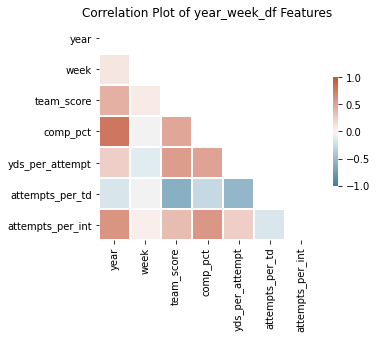

In [6]:
year_week_df_corr = year_week_df.corr()
year_week_df_corr

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20plot
mask = np.triu(np.ones_like(year_week_df_corr, dtype=bool))
fig1, ax1 = plt.subplots()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(year_week_df_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax1.set_title('Correlation Plot of year_week_df Features')

In [7]:
print(f'team_score to year pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.year)}')
print(f'team_score to week pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.week)}')
print(f'team_score to comp_pct pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.comp_pct)}')
print(f'team_score to yds_per_attempt pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.yds_per_attempt)}')
print(f'team_score to attempts_per_td pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.attempts_per_td)}')
print(f'team_score to attempts_per_int pearsonr values: {pearsonr(year_week_df.team_score, year_week_df.attempts_per_int)}')

team_score to year pearsonr values: (0.43422248014265136, 4.119212622058075e-36)
team_score to week pearsonr values: (0.06945354871304753, 0.05628758982651029)
team_score to comp_pct pearsonr values: (0.4872382892743197, 2.5072043032147727e-46)
team_score to yds_per_attempt pearsonr values: (0.5472246043381017, 2.83825639544395e-60)
team_score to attempts_per_td pearsonr values: (-0.5954678571934553, 9.938139841308596e-74)
team_score to attempts_per_int pearsonr values: (0.35166885882490556, 1.9885096772926563e-23)


#### Box and Scatterplot Explorations of the year_week_df Dataframe

Conventional wisdom states that teams are scoring more points in the recent past than at other times in the past.  Based on a review of the available data and performing a boxplot of the yearly team score means, it does appear that scoring, on average, has trended up since 1970.  At different points, the upward trajectory was broken. For example, the following periods defied the 47 year trend:

- 1976 - 1978
- 1991 - 1993
- 2001 - 2003

During visual inspection of the annual scoring boxplots, the frequency of outliers has decreased and the whiskers have gradually grown closer to the boxes since the late 1990s. The general shrinking of the whiskers indicates that there is decreasing variance in the amount of points teams score every year. In other words, the NFL is full of teams that all score approximately the same number of points. Based on recent trends, gone are the days of a few excellent and a few dreadful offensive teams. Based on the p-values calculated above, quarterback performance ratios can explain the increase and consistency seen in the box plots.

Text(0, 0.5, 'Team Score')

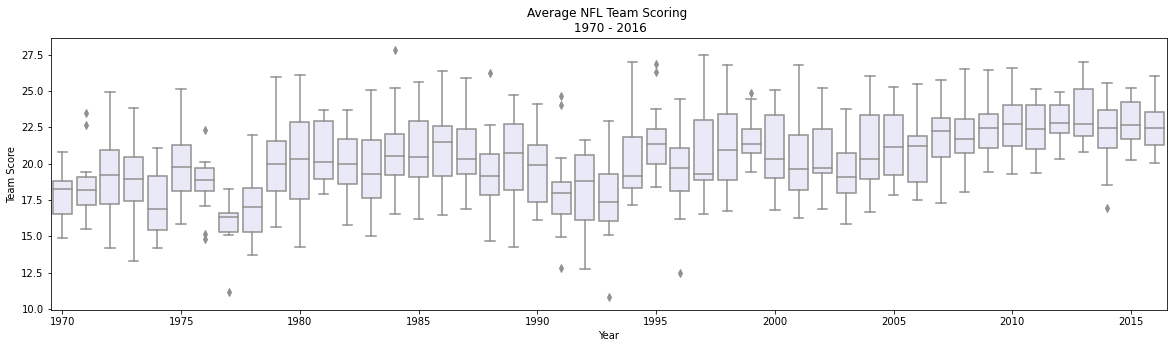

In [8]:
tick_spacing = 5

fig2, ax1 = plt.subplots(figsize=(20, 5))

sns.boxplot(x = 'year', y = 'team_score', data=year_week_df, color='lavender', ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.set_title('Average NFL Team Scoring \n 1970 - 2016')
ax1.set_xlabel('Year')
ax1.set_ylabel('Team Score')

Below is a series of scatterplots and associated residual plots depicting the relationships between the features and the target variable, team_score. These plots depict generally linear relationships between the chosen features.  The residual plots show generally homoskedastic conditions for the plotting variable pairings. Two of the residual plots (attempts_per_int vs year & attempts_per_td vs year) show generally homoskedastic conditions, but are influenced by some large residual values.  

Over the 47 years of data:

- team scoring has consistently trended upward, showing agreement with the box plot
- team scoring has increased in-season from week 1 to week 16

The scatter plots clearly show that over years, quarterback performance has improved. The improvement in quarterback performance, in general, would indicate that scoring should be increasing over time, in accordance with the boxplot. Key takeaways about performance improvement:

- with each successive year, quarterback completion percentage has increases
- as completion percentage increases, team score increases
- as years increase, the number of passing attempts between touchdowns decreases
- as years increase, the number of passing attempts between interceptions increases
- as yards per attempt increase, completion percent increases

One interesing find came from the scatterplots. When comparing completion percentage on a week-to-week basis, the rate drops between week 1 and week 16 despite the general trend upward when viewing from the year-to-year level. I think an explanation for this is that as a year goes on, the chance for quarterbacks to become injured, miss time and be replaced by less capable backups and poor weather would all contribute to a lower of completion percentage. I believe the year-to-year trend holds because the in-season decrease is only a small change, which would not halt the year-to-year trend.

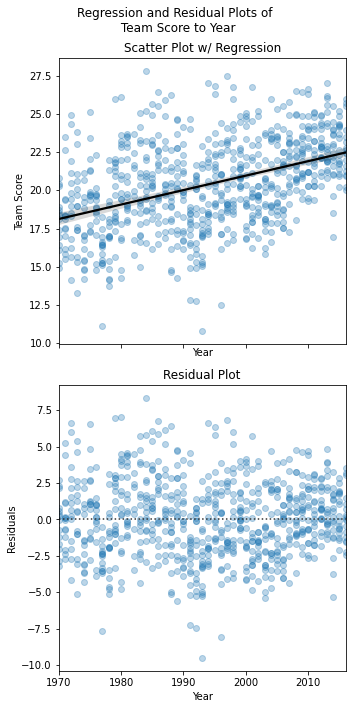

In [9]:
fig3, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='year', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='year', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig3.suptitle('Regression and Residual Plots of \n Team Score to Year')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Year')
ax1.set_ylabel('Team Score')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Year')
ax2.set_ylabel('Residuals')
fig3.tight_layout()

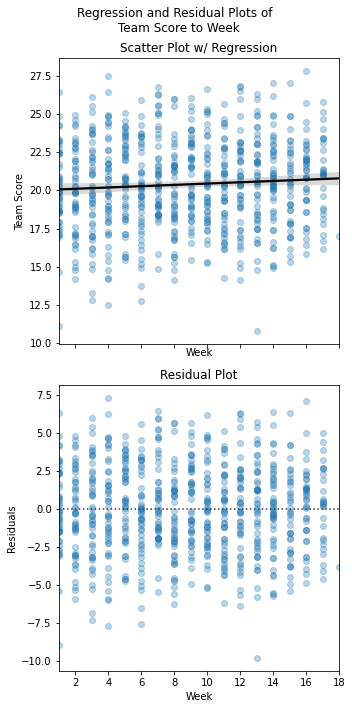

In [10]:
fig4, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='week', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='week', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig4.suptitle('Regression and Residual Plots of \n Team Score to Week')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Week')
ax1.set_ylabel('Team Score')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Week')
ax2.set_ylabel('Residuals')
fig4.tight_layout()

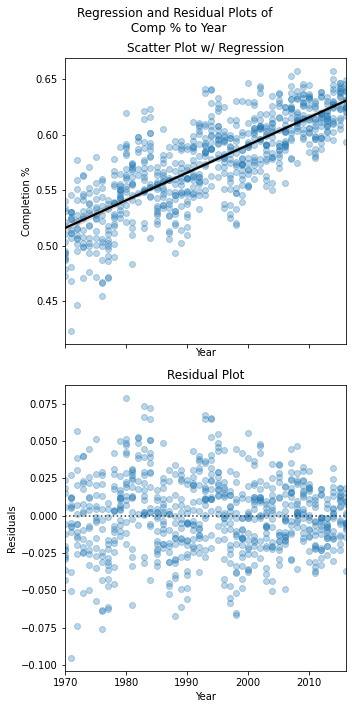

In [11]:
# https://stackoverflow.com/questions/33005872/seaborn-regplot-partially-see-through-alpha
# https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot/48146987

fig5, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='year', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='year', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig5.suptitle('Regression and Residual Plots of \n Comp % to Year')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Year')
ax1.set_ylabel('Completion %')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Year')
ax2.set_ylabel('Residuals')
fig5.tight_layout()

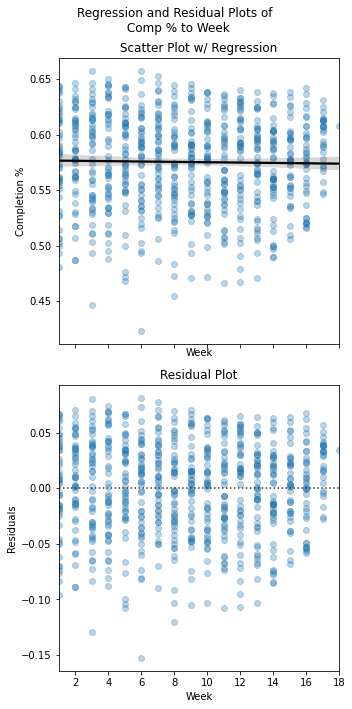

In [12]:
fig6, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='week', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='week', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig6.suptitle('Regression and Residual Plots of \n Comp % to Week')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Week')
ax1.set_ylabel('Completion %')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Week')
ax2.set_ylabel('Residuals')
fig6.tight_layout()

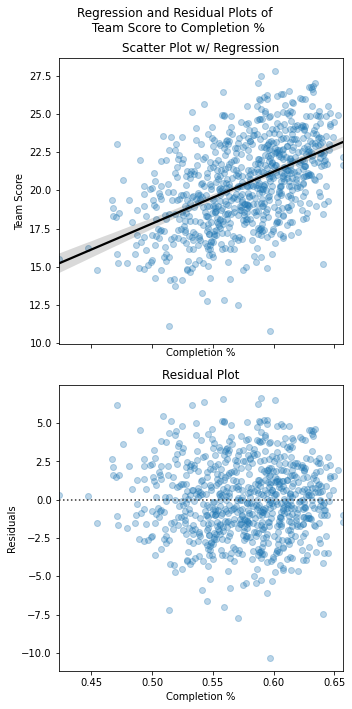

In [13]:
fig7, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='comp_pct', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='comp_pct', y='team_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig7.suptitle('Regression and Residual Plots of \n Team Score to Completion %')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Completion %')
ax1.set_ylabel('Team Score')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Completion %')
ax2.set_ylabel('Residuals')
fig7.tight_layout()

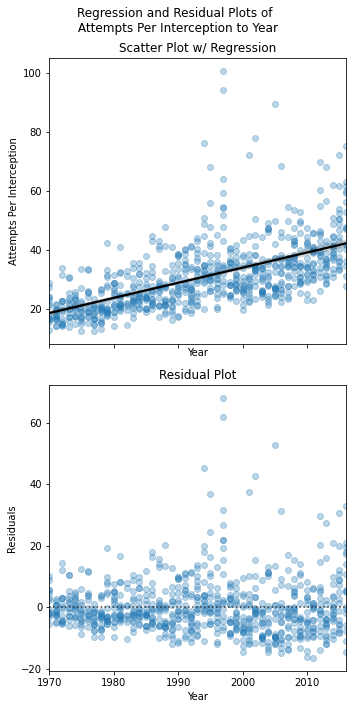

In [14]:
fig8, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='year', y='attempts_per_int', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='year', y='attempts_per_int', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig8.suptitle('Regression and Residual Plots of \n Attempts Per Interception to Year')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Year')
ax1.set_ylabel('Attempts Per Interception')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Year')
ax2.set_ylabel('Residuals')
fig8.tight_layout()

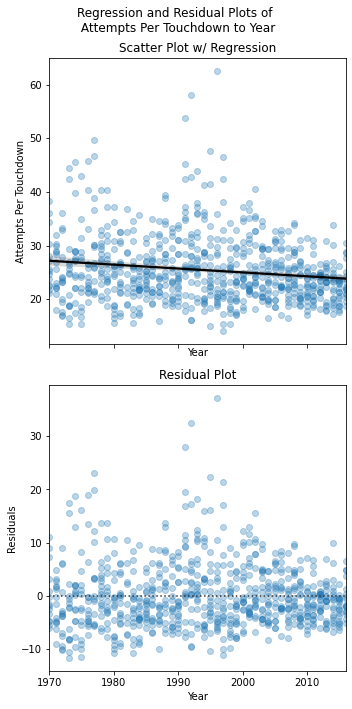

In [15]:
fig9, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='year', y='attempts_per_td', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='year', y='attempts_per_td', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig9.suptitle('Regression and Residual Plots of \n Attempts Per Touchdown to Year')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Year')
ax1.set_ylabel('Attempts Per Touchdown')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Year')
ax2.set_ylabel('Residuals')
fig9.tight_layout()

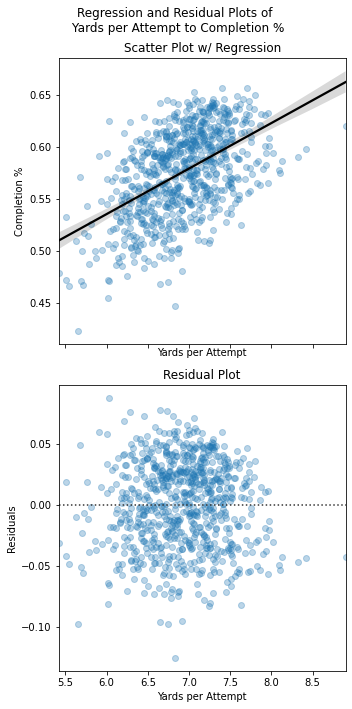

In [16]:
fig10, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)
sns.regplot(data=year_week_df, x='yds_per_attempt', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax1)
sns.residplot(data=year_week_df, x='yds_per_attempt', y='comp_pct', scatter_kws={'alpha': 0.3}, line_kws={'color': 'black'}, ax=ax2)

fig10.suptitle('Regression and Residual Plots of \n Yards per Attempt to Completion %')
ax1.set_title('Scatter Plot w/ Regression')
ax1.set_xlabel('Yards per Attempt')
ax1.set_ylabel('Completion %')
ax2.set_title('Residual Plot')
ax2.set_xlabel('Yards per Attempt')
ax2.set_ylabel('Residuals')
fig10.tight_layout()

# Supervised Learning

### Dataset Preparation

Establish X values dataframe (and constant for intercept) and y series of target values (team_score).

In [17]:
# create x and y datasets
# https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

X = year_week_df.drop(['team_score', 'year', 'week'], axis=1)
X = sm.add_constant(X)
variables = ['const', 'comp_pct', 'yds_per_attempt', 'attempts_per_td', 'attempts_per_int']
y = year_week_df['team_score']

# display(X.shape)
# display(y.head(10))

Establish training and test datasets from the X dataframe and y series.

In [18]:
# split X and y datasets into training and test sets
# https://www.youtube.com/watch?v=zM4VZR0px8E

train_pct = 0.8
test_pct = 0.2
rand_seed = 1
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_pct,
                                                    test_size = test_pct,
                                                    random_state = rand_seed)


### Model Training

#### Linear Regression

The linear regression model performed well when fitted with the training dataset. The R-Squared value came in at 0.502. This is an impressive finding considering it suggests that about 50% of the increase in team scoring between 1970 and 2016 can be explained by the improvement in quarterback performance as measured by a handful of performance ratio statistics.

In [19]:
base_ols = sm.OLS(y_train, X_train)
fit_ols = base_ols.fit()
fit_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             team_score   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     151.2
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           2.42e-89
Time:                        23:51:08   Log-Likelihood:                -1296.2
No. Observations:                 604   AIC:                             2602.
Df Residuals:                     599   BIC:                             2624.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.2433      1.861      4.430      0.000       4.589      11.898
comp_pct            17.2037      2.854      6.027      0.000      11.598      22.809
yds_per_attempt      0.9960      0.226      4.398      0.000       0.551       1.441
attempts_per_td     -0.2060      0.016    -12.734      0.000      -0.238      -0.174
attempts_per_int     0.0218      0.009      2.302      0.022       0.003       0.040
==============================================================================
Omnibus:                        0.270   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.171
Skew:                          -0.032   Prob(JB):                        0.918
Kurtosis:                       3.053   Cond. No.                     1.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

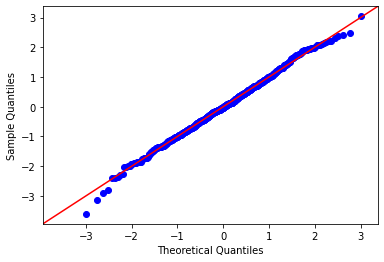

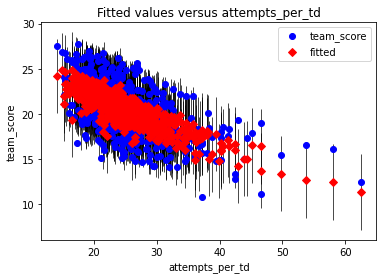

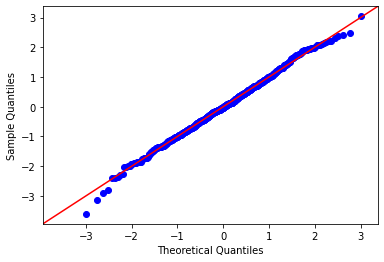

In [20]:
sm.graphics.plot_fit(fit_ols, 'attempts_per_td')
sm.graphics.qqplot(fit_ols.resid, stats.t, fit=True, line='45')


#### K Nearest Neighbors

In [21]:
base_knn = KNeighborsRegressor(n_neighbors = 5)
fit_knn = base_knn.fit(X_train, y_train)


#### Decision Tree

The decision tree determined that the statistic, attempts_per_td was the single most important variable by it's placement at the root of the tree. The placement of this statistic as the root makes sense because if a quarterback can in decrease this rate, the team ought to be scoring more than if the rate is higher.

Traveling down the tree, the left side of the tree is associated higher team scores. The left side end points range in predicted values from (20.1, 24.4) points. The right side of the tree is associated with lower team scores. The right side end point range in predicted values from (14.9, 20.4). The disparity in predicted team scores is stark considering left side's lowest predicted value is essentially the same as the right side's highest predicted value. At the other extreme of predicted points, there is a two score difference (9.5 points). 

[Text(837.0, 475.65000000000003, 'attempts_per_td <= 24.592\nmse = 8.603\nsamples = 604\nvalue = 20.475'),
 Text(418.5, 339.75, 'comp_pct <= 0.586\nmse = 5.905\nsamples = 334\nvalue = 21.861'),
 Text(209.25, 203.85000000000002, 'attempts_per_td <= 20.039\nmse = 4.85\nsamples = 149\nvalue = 20.654'),
 Text(104.625, 67.94999999999999, 'mse = 4.437\nsamples = 48\nvalue = 21.847'),
 Text(313.875, 67.94999999999999, 'mse = 4.048\nsamples = 101\nvalue = 20.087'),
 Text(627.75, 203.85000000000002, 'attempts_per_td <= 19.96\nmse = 4.635\nsamples = 185\nvalue = 22.834'),
 Text(523.125, 67.94999999999999, 'mse = 2.951\nsamples = 58\nvalue = 24.409'),
 Text(732.375, 67.94999999999999, 'mse = 3.754\nsamples = 127\nvalue = 22.114'),
 Text(1255.5, 339.75, 'attempts_per_td <= 31.496\nmse = 6.626\nsamples = 270\nvalue = 18.761'),
 Text(1046.25, 203.85000000000002, 'comp_pct <= 0.568\nmse = 5.676\nsamples = 188\nvalue = 19.458'),
 Text(941.625, 67.94999999999999, 'mse = 5.633\nsamples = 97\nvalue = 18.

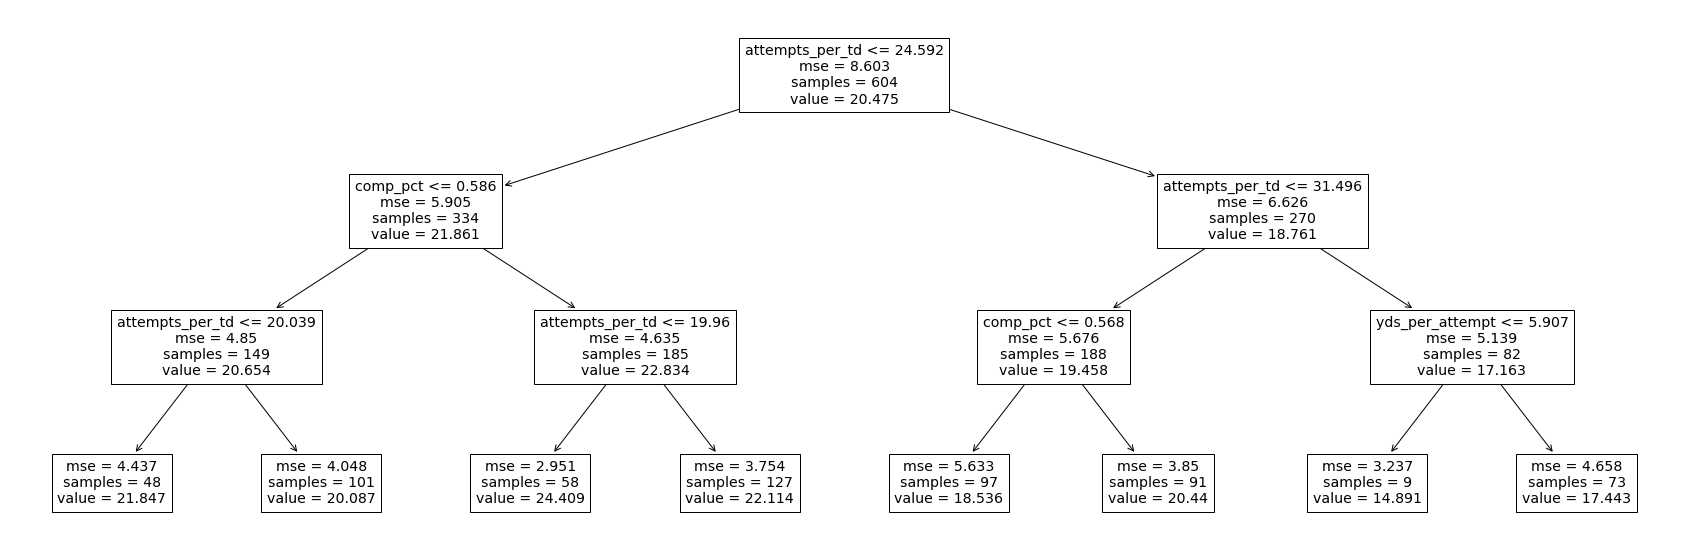

In [22]:
base_tree = DecisionTreeRegressor(max_depth=3, random_state=rand_seed)
fit_tree = base_tree.fit(X_train, y_train)

fig53, ax1 = plt.subplots(figsize=(30,10))
plot_tree(fit_tree, feature_names=variables)

#### Random Forest

The random forest ensemble confirms attempts_per_td as the single most important variable in determining a team's score. Based on the variable importance plot, attempts_per_td, explains >40% of the variance of the model. The rest of the variables explain between ~15-21% of the model variance.

In [23]:
base_rf = RandomForestRegressor(random_state=rand_seed)
fit_rf = base_rf.fit(X_train, y_train)

<BarContainer object of 5 artists>

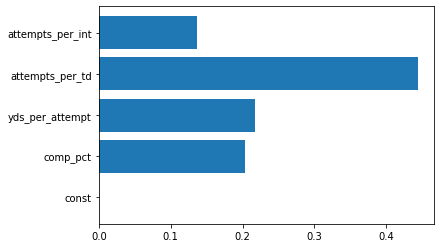

In [24]:
plt.barh(variables, fit_rf.feature_importances_)

### Model Testing

After performing model testing with the testing dataset (X_test), the RMSE for each model was calculated. All four models performed similarly. The RMSEs ranged between (2.063, 2.235). Put another way, the models are all within the margin of a single 3-point field goal.  As measured by RMSE, the linear model (fit_ols) performed the best (RMSE = 2.063). The Tree model performed the worst at 2.235.

In [25]:
y_preds_ols = fit_ols.predict(X_test)
y_preds_knn = fit_knn.predict(X_test)
y_preds_tree = fit_tree.predict(X_test)
y_preds_rf = fit_rf.predict(X_test)

# print(y_preds_ols)
# print(y_preds_knn)
# print(y_preds_tree)
# print(y_preds_rf)

In [26]:
rmse_ols = np.sqrt(np.mean((y_test - y_preds_ols) ** 2))
rmse_knn = np.sqrt(np.mean((y_test - y_preds_knn) ** 2))
rmse_tree = np.sqrt(np.mean((y_test - y_preds_tree) ** 2))
rmse_rf = np.sqrt(np.mean((y_test - y_preds_rf) ** 2))

print(f'RMSE OLS: {rmse_ols.round(3)}, RMSE KNN: {rmse_knn.round(3)}, RMSE Tree: {rmse_tree.round(3)}, RMSE RF: {rmse_rf.round(3)}')

RMSE OLS: 2.063, RMSE KNN: 2.194, RMSE Tree: 2.235, RMSE RF: 2.11


### Model Predictions 

I plotted each of the four models alongside each other to visually represent the team score prediction based on varying attempts per touchdown pass. Also shown are the actual observations. The dataframe supplying the plot features the same features as the training and test datasets. The attempts_per_td column ranges from 0 to 50 while all other columns are the mean of that column. In other words, the plot depicts what the average team would score with varying levels of quarterback pass attempts to touchdown efficiency. The more efficient the quarterback is (fewer attempts per td pass) the higher the average team score, the less efficient the quarterback is (greater attempts per td pass) the lower the average team score. 

The linear model (fit_ols) by RMSE was best suited for predicted team score. In the plot, it seems to decently capture the trend of the observed data points.  The tree (fit_tree), knn (fit_knn), and rf (fit_rf) all generally stair-step the same down the team score axis as attempts per td increase. fit_knn line is more erratic than tree or rf as attempts per touchdown increase.  The erratic line is due to the tree and rf being based on splits in the data going from one group based on a condition to another. knn has more flexibility in this regard, so the stair-step effect is diminished. 

In [27]:
att_per_td = np.arange(0, 50)

df_preds = pd.DataFrame([], columns = variables)
df_preds['attempts_per_td'] = att_per_td
df_preds['const'] = X.const.mean()
df_preds['comp_pct'] = X.comp_pct.mean()
df_preds['yds_per_attempt'] = X.yds_per_attempt.mean()
df_preds['attempts_per_int'] = X.attempts_per_int.mean()

y_preds2_ols = fit_ols.predict(df_preds)
y_preds2_knn = fit_knn.predict(df_preds)
y_preds2_tree = fit_tree.predict(df_preds)
y_preds2_rf = fit_rf.predict(df_preds)

Text(0, 0.5, 'Average Team Score')

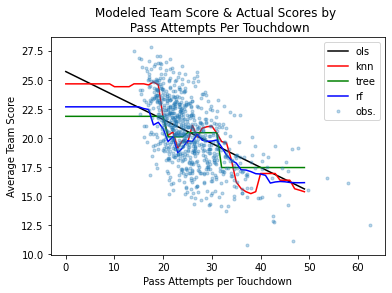

In [28]:
fig11, ax1 = plt.subplots()

plt.plot(att_per_td, y_preds2_ols, 'k', label='ols')
plt.plot(att_per_td, y_preds2_knn, 'r', label='knn')
plt.plot(att_per_td, y_preds2_tree, 'g', label='tree')
plt.plot(att_per_td, y_preds2_rf, 'b', label='rf')
plt.plot(year_week_df.attempts_per_td, year_week_df.team_score,'.', alpha=0.3, label='obs.')
plt.legend()
plt.title('Modeled Team Score & Actual Scores by \n Pass Attempts Per Touchdown')
plt.xlabel('Pass Attempts per Touchdown')
plt.ylabel('Average Team Score')

#### Predict Team Score For a Team

In [29]:
# a lower and upper range bound to select a section of the observations
# dataset has 756 oberservations

lower = 400
upper = 405
random_obs = range(lower, upper)

random_obs_df = X.iloc[random_obs]
print('The user-selected range of observations are listed in the following dataframe:')
display(random_obs_df)
random_obs_df_index = random_obs_df.index

y_rand_preds = y.iloc[random_obs]
y_rand_preds = y_rand_preds.to_frame()
y_rand_preds = y_rand_preds.rename(columns = {'team_score': 'Team Score_mean'})
# display(y_rand_preds)
# print(type(y_rand_preds))

ols_rand_preds = pd.DataFrame(fit_ols.predict(random_obs_df), columns=['Team Score_ols']).set_index(random_obs_df_index)
knn_rand_preds = pd.DataFrame(fit_knn.predict(random_obs_df), columns=['Team Score_knn']).set_index(random_obs_df_index)
tree_rand_preds = pd.DataFrame(fit_tree.predict(random_obs_df), columns=['Team Score_tree']).set_index(random_obs_df_index)
rf_rand_preds = pd.DataFrame(fit_rf.predict(random_obs_df), columns=['Team Score_rf']).set_index(random_obs_df_index)

# display(ols_rand_preds)
# display(knn_rand_preds)
# display(tree_rand_preds)
# display(rf_rand_preds)

rand_obs_model_results_df = pd.concat([y_rand_preds, ols_rand_preds, knn_rand_preds, tree_rand_preds, rf_rand_preds], axis='columns')
print('\nThe following table reports the model predicted team scores for each observation for each model:')
rand_obs_model_results_df



The user-selected range of observations are listed in the following dataframe:


,const,comp_pct,yds_per_attempt,attempts_per_td,attempts_per_int
year_week,,,,,
1996_2,1.0,0.578842,7.293413,20.040000,33.400000
1996_3,1.0,0.602871,6.877990,22.000000,19.904762
1996_4,1.0,0.570667,5.672000,62.500000,25.000000
1996_5,1.0,0.598187,7.126888,20.687500,30.090909
1996_6,1.0,0.580925,7.002890,20.352941,31.454545



The following table reports the model predicted team scores for each observation for each model:


,Team Score_mean,Team Score_ols,Team Score_knn,Team Score_tree,Team Score_rf
year_week,,,,,
1996_2,19.850000,22.065245,21.255792,20.086947,20.431733
1996_3,22.500000,21.366869,22.300150,22.114211,22.065479
1996_4,12.500000,11.378818,14.359168,14.890818,13.565435
1996_5,17.153846,22.026654,20.753374,22.114211,19.189100
1996_6,21.090909,21.704824,20.886327,20.086947,20.735283


# Conclusions

#### Takeaways

Based on the preceding analysis on Kendall Gillies' Game Logs Quarterback dataset, it is clear that the general increase of team scoring in the NFL from 1970 to 2016 can in large part be explained by quarterback performance, as measured by completion percentage, yards per pass attempt, pass attempts per touchdown, and pass attempts per interception. Each variable, when correlated with team score shows a moderate-to-strong linear association. The level of statistical significance is well below the 0.05 threshold signaling that the effect is not present by chance alone.

This finding, the significance of quarterback performance relative to team scores is remarkable. Football is a game played by 11 players on offense and yet, based on this analysis, the quarterback's performance can explain upwards of 50% of the variability in team scoring since 1970 (as per the fit_ols R-squared). The importance of the quarterback's performance cannot be understated and seemingly justifies the obsession placed on the position by teams and the media. Because quarterback performance has such an effect on team score, the proportion of team salary caps paid to quarterbacks is seemingly justified.

Conventional wisdom states that quarterback play in general has improved over time due to changes in offensive philosophy, namely the greater reliance on mid-to-short passes instead mid-to-long passes. The thinking is that quarterbacks will have a higher completion percentage (greater efficiency) with shorter, easier throws.  This conventional wisdom is both supported and not supported by the trends shown in the plots above. 

In the yards per attempt vs completion percent plot, it is clear that as yards per attempt increases, so does completion percentage. A possible explanation for this finding could be that yes, quarterbacks are throwing shorter and more often, but receivers have greater abilities to accumulate yards after the catch due to skill and poor tackling by the opposing defense.

The completion percentage vs year plot shows a clear upward trend in completion percentage since 1970, indicating that yes, quarterbacks are more better able to connect with receivers. The cause of this effect may in fact be due to changes in offensive philosophies that deemphasize throws further down the field.

The number of pass attempts per interception has increased since 1970 as well. Because interceptions are becoming less common, offenses have more opportunities to score if for no other reason than they give the opposing team fewer opportunities to score.  The decrease in interceptions may again, be due to the aforementioned contemporary offensive philosophy emphasizing shorter throws.

#### Recommendations

As result of this analysis, I would recommend the following:

- Include quarterbacks that were not included in initial dataset (ie Joe Montana, Terry Bradshaw)
- Include data from 2017 - 2020 seasons
- Account for offensive philosophy changes over time
- Account for player performances of other offensive positions

These recommendations would create a more complete understanding into why team scoring has increased over time. It would also become evident the degree to which each position group contributes to that increase, which could be used to determine team salary cap allocations.

# Presentation

This section is a placeholder for the Presentation grade. No need to do anything here.